# Tutorial for MCMC regression 

___Author: Vivek M___

---

## Description

This jupyter-notebook introduces the basics of MCMC regression fit using various packages like __emcee__, __pymc__, and discuss what MCMC does qualitatively.

First thing: ___MCMC stands for Markov-Chain Monte Carlo___

## Monte Carlo


Monte Carlo methods, or Monte Carlo experiments, are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle.

## Markov Chain

A Markov chain is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. In continuous-time, it is known as a Markov process. It is named after the Russian mathematician Andrey Markov.

A Markov process is a stochastic process that satisfies the Markov property[1] (sometimes characterized as "memorylessness"). In simpler terms, it is a process for which predictions can be made regarding future outcomes based solely on its present state and--most importantly--such predictions are just as good as the ones that could be made knowing the process's full history.

A famous Markov chain is the so-called "drunkard's walk", a random walk on the number line where, at each step, the position may change by +1 or −1 with equal probability. From any position there are two possible transitions, to the next or previous integer. The transition probabilities depend only on the current position, not on the manner in which the position was reached. For example, the transition probabilities from 5 to 4 and 5 to 6 are both 0.5, and all other transition probabilities from 5 are 0. These probabilities are independent of whether the system was previously in 4 or 6.

Another example is the dietary habits of a creature who eats only grapes, cheese, or lettuce, and whose dietary habits conform to the following rules:

- It eats exactly once a day.
- If it ate cheese today, tomorrow it will eat lettuce or grapes with equal probability.
- If it ate grapes today, tomorrow it will eat grapes with probability 1/10, cheese with probability 4/10, and lettuce with probability 5/10.
- If it ate lettuce today, tomorrow it will eat grapes with probability 4/10 or cheese with probability 6/10. It will not eat lettuce again tomorrow.

This creature's eating habits can be modeled with a Markov chain since its choice tomorrow depends solely on what it ate today, not what it ate yesterday or any other time in the past. One statistical property that could be calculated is the expected percentage, over a long period, of the days on which the creature will eat grapes.

In [649]:
import emcee
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import corner
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

### Creating the synthetic data 

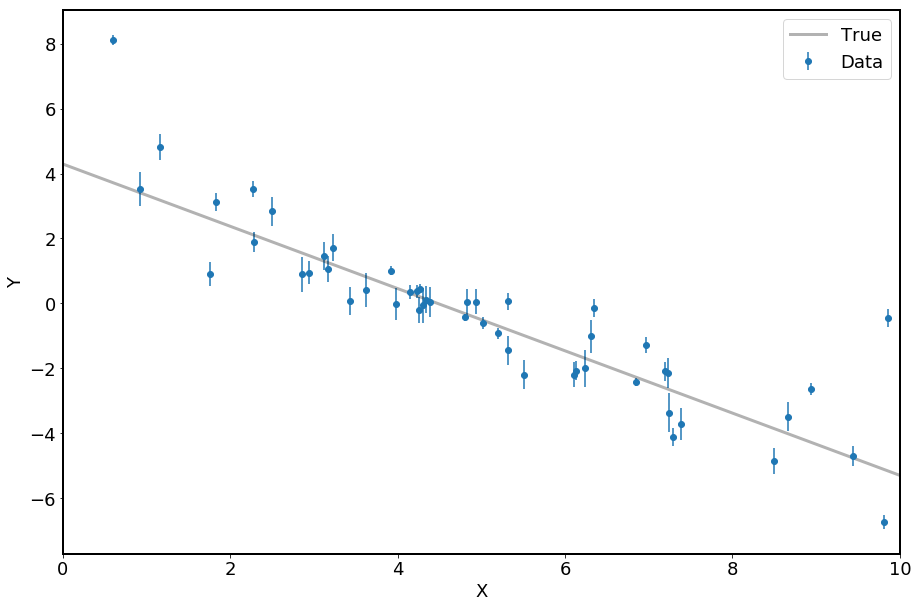

In [650]:
np.random.seed(123)
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534
# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)
#Plotting the data
#plt.plot(x,y,'o')
plt.errorbar(x,y,yerr=yerr,fmt='o',label='Data')
plt.xlabel('X')
plt.ylabel('Y')
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3,label='True')
plt.xlim(0, 10)
plt.legend()

### Using Least squares method

In [651]:
#    Irritatingly, scipy.odr and scipy.optimize.curve_fit require x & p
#    in opposite orders, so to be consistent with functions defined for
#    curve_fit we use a little "swapped" wrapper function.
def linemodel(params,x):
    m,c = params[0],params[1]
    return m*x+c

def linemodel_curvefit(x,m,c):
    return m*x+c

In [652]:
def residuals(params, y,yerr, x):
    '''
        scipy.optimize.leastsq minimizes the sum of squares of the function given as an argument.
    '''
    return ((y - linemodel( params,x))/yerr)

In [653]:
from scipy.optimize import leastsq
from scipy.optimize import curve_fit

In [654]:
p0=np.array([1, 1], dtype=float)

lx,lcov, linfodict, lerrmsg, lsuccess  = leastsq(residuals, p0, args=(y,yerr, x),full_output=1)
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(lx[0], np.sqrt(lcov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(lx[1], np.sqrt(lcov[1, 1])))

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


### Using np.linalg method

In [655]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))


Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


### Using curve_fit method

The main difference between leastsq and curve_fit is that leastsq requires the residuals as the input model to minimize. Curve_fit requires the model itself to minimize. For eg. in this example, residuals function is the input to the leastsq where as linemodel funciton is the input to the curve_fit.



In [656]:
#https://stackoverflow.com/questions/27696324/using-scipy-optimize-curve-fit-with-weights
pfit, pcov = curve_fit(linemodel_curvefit,x,y,p0=lx,sigma=yerr,absolute_sigma=True) #absolute_sigma=True
print("#Fit parameters and parameter errors from curve_fit method :")
print("m = {0:.3f} ± {1:.3f}".format(pfit[0], np.sqrt(pcov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(pfit[1], np.sqrt(pcov[1, 1])))


#Fit parameters and parameter errors from curve_fit method :
m = -1.104 ± 0.016
b = 5.441 ± 0.091


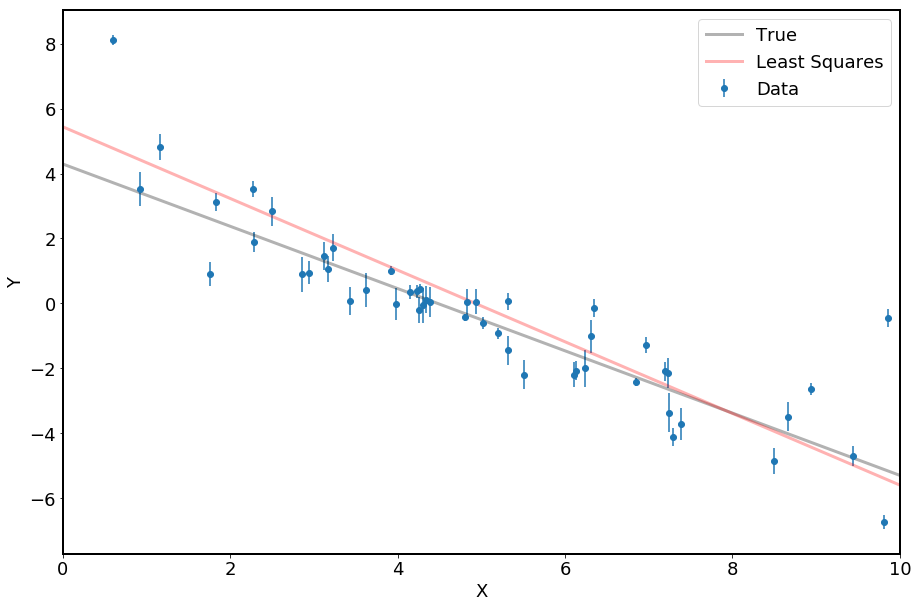

In [657]:
#Plotting the data
#plt.plot(x,y,'o')
plt.errorbar(x,y,yerr=yerr,fmt='o',label='Data')
plt.xlabel('X')
plt.ylabel('Y')
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3,label='True')
plt.plot(x0, lx[0]* x0 + lx[1], "r", alpha=0.3, lw=3,label='Least Squares')

plt.xlim(0, 10)
plt.legend()


### Using Orthogonal Distance regression method

In [658]:
from scipy.odr import Model, RealData,Data ,ODR
# Create a model for fitting.
linear = Model(linemodel)
# Create a RealData object using our initiated data from above.
# we is the standard deviation in y, the weights are calculated by 1.0/we**2
mydata = RealData(x, y, sy=yerr )# if xerr, give sx = xerr,wd=1/xerr
# Set up ODR with the model and data.
myodr = ODR(mydata, linear, beta0=[1., 1.])
# Run the regression.
myoutput = myodr.run()
# Use the in-built pprint method to give us results.
print myoutput.pprint()


Beta: [-1.23493459  5.86863303]
Beta Std Error: [0.09158009 0.49821878]
Beta Covariance: [[ 0.0074482  -0.03734475]
 [-0.03734475  0.22043945]]
Residual Variance: 1.12603238338
Inverse Condition #: 0.0644777355524
Reason(s) for Halting:
  Sum of squares convergence
None


In [659]:
#likelihood function
def lnlike(theta,x,y,yerr):
    m,b,log_f = theta
    model = m*x+b
    sigma2 = yerr**2 + np.exp(2*log_f)*model**2
    return -0.5*np.sum( (y-model)**2 / sigma2 +np.log(sigma2))
                      
#prior
def lnprior(theta):
    m,b,log_f = theta
    #gaussian prior on a
    #mu = 10
    #sigma = 1
    #return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(a-mu)**2/sigma**2
    
    # uniform prior
    if -5.0 < m < 0.5 and 0.0 < b < 10 and -1.0 <log_f < 1.0:
        return 0.0
    return -np.inf
    
#log Probability
def lnprob(theta, x,y,yerr):
    m,b,log_f = theta
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnprior(theta)+ lnlike(theta,x,y,yerr)


### Minimize the negative log likelihood using scipy.optimize

In [660]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -lnlike(*args)
initial = np.array([pfit[0],pfit[1],np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x
print("#Fit parameters  from minimizing negative log likehihood method :")
print("m = {0:.3f} ".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

#Fit parameters  from minimizing negative log likehihood method :
m = -1.003 
b = 4.528
f = 0.454


In [661]:
import emcee

niter = 2000
nwalkers = 1000
ndim = 3 # number of parameters to fit

#Remember to give the initial parameters from the prior distribution, i.e, one should not give
#values outside the prior distribution. Recommended method is to first run scipy.optimize and 
#give the result as the input for the initial parameters
initial = np.array([pfit[0],pfit[1],np.log(f_true)])
print initial

# The following step is to set the initial point for the nwalkers. We will offset the nwalkers 
#by a small amount so that the nwalkers fully covers the parameter space
pos = np.array(initial)+ 1e-4 * np.random.randn(nwalkers, ndim)
#pos = [np.array(initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

print("Running burn-in...")
pos, _, _ = sampler.run_mcmc(pos, 100,progress=True)
sampler.reset()

  0%|          | 0/100 [00:00<?, ?it/s]

[-1.1040757   5.44055525 -0.62735944]
Running burn-in...


100%|██████████| 100/100 [00:02<00:00, 33.77it/s]


In [662]:
print("Running production...")
pos, prob, state = sampler.run_mcmc(pos, niter,progress=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

Running production...


100%|██████████| 2000/2000 [01:00<00:00, 32.86it/s]


(2000000,)


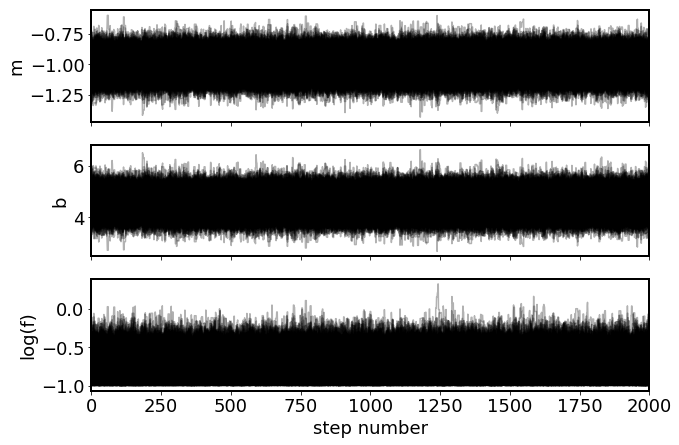

In [663]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print samples[:,:,i].flatten().shape
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [664]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(126000, 3)


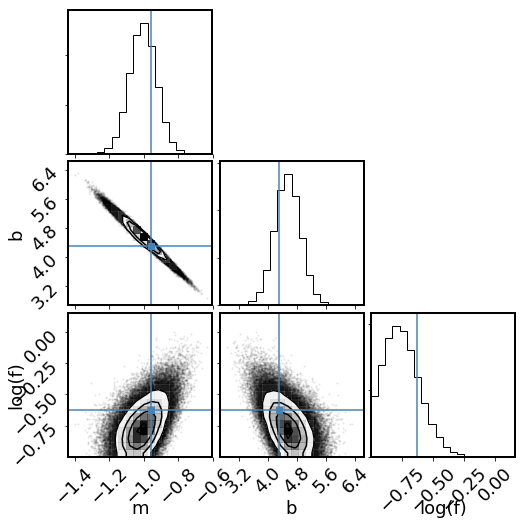

In [665]:
import corner

fig = corner.corner(
    flat_samples, labels=labels,truths=[m_true, b_true, np.log(f_true)]);

In [666]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

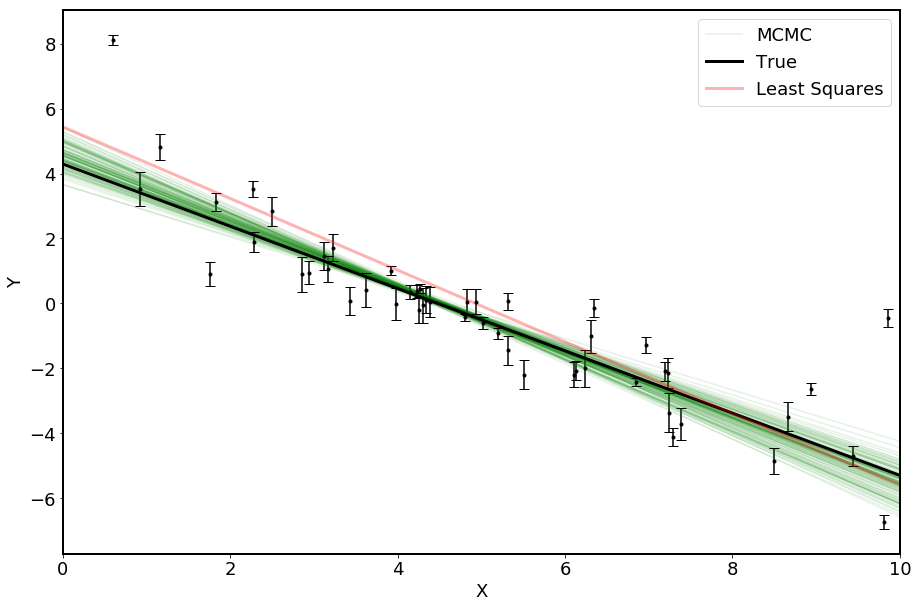

In [667]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "g", alpha=0.1)
    if ind == inds[-1]:
            plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "g", alpha=0.1,label='MCMC')


plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=5)
plt.plot(x0, m_true * x0 + b_true, "k",lw=3, label="True")
plt.plot(x0, lx[0]* x0 + lx[1], "r", alpha=0.3, lw=3,label='Least Squares')

plt.legend()
plt.xlim(0, 10)
plt.xlabel("X")
plt.ylabel("Y");

### Using PyMC

In [668]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))


Running on PyMC3 v3.6


In [669]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    m = pm.Normal('m', mu=0, sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    #log_f =pm.HalfNormal('log_f', sd=1)

    # Expected value of outcome
    mu =   m*x+b  
    #sigma2 = np.sqrt(yerr**2+np.exp(2*log_f)*mu**2)
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=yerr, observed=y)


In [670]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = -2,942.3, ||grad|| = 5,008: 100%|██████████| 8/8 [00:00<00:00, 879.49it/s]


{'b': array(5.44009077), 'm': array(-1.10399939)}

In [671]:
with basic_model:
    # draw 5000 posterior samples
    trace = pm.sample(5000,cores=4)

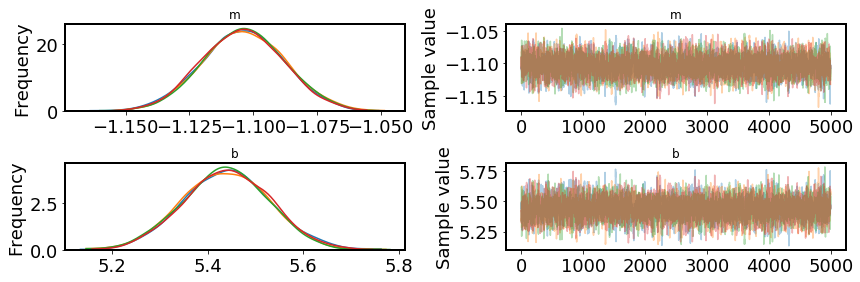

In [672]:
pm.traceplot(trace);


In [673]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,-1.103837,0.015983,0.000214,-1.135141,-1.072392,5004.563909,1.000415
b,5.439142,0.089593,0.001257,5.266461,5.615447,4948.069405,1.000527


In [674]:
print trace[1],trace[0]

{'b': 5.426769803292898, 'm': -1.090457641398984} {'b': 5.416473872004658, 'm': -1.0943967779316095}


In [695]:
tdf = pm.trace_to_dataframe(trace)

In [697]:
tdf

,b,m
0,5.440519,-1.106429
1,5.489712,-1.109195
2,5.473984,-1.107989
3,5.437362,-1.103939
4,5.396918,-1.097818
5,5.392686,-1.096949
6,5.361754,-1.096117
7,5.335231,-1.077988
8,5.563115,-1.121716
9,5.455537,-1.093213
